In [178]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima_model import ARIMA

In [179]:
COVID_ = pd.read_csv('covid_19_data.csv')
COVID = COVID_.copy()
COVID_['Data']= pd.to_datetime(COVID_['ObservationDate']).dt.date
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date

In [180]:
COVID = COVID.groupby(['Data','Country/Region'])['Confirmed','Deaths','Recovered'].sum()

### EDA

In [181]:
rus_data = COVID.loc[COVID.index.get_level_values('Country/Region')=='Russia', ['Confirmed','Deaths','Recovered']]

In [182]:
rus_data.index = pd.to_datetime(rus_data.index.droplevel(1))

In [183]:
rus_data.tail(1)

,Confirmed,Deaths,Recovered
Data,,,
2020-04-13,18328.0,148.0,1470.0


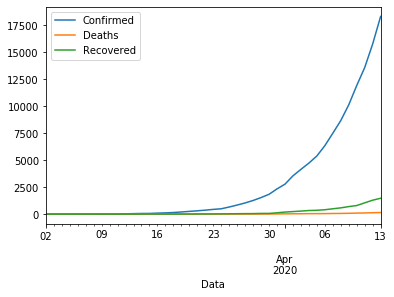

In [184]:
rus_data.loc[(rus_data.index.get_level_values('Data') > pd.to_datetime('2020-03-01')), ['Confirmed','Deaths','Recovered']].plot()
plt.show()

Посмотрим на первые разности прироста заболевших

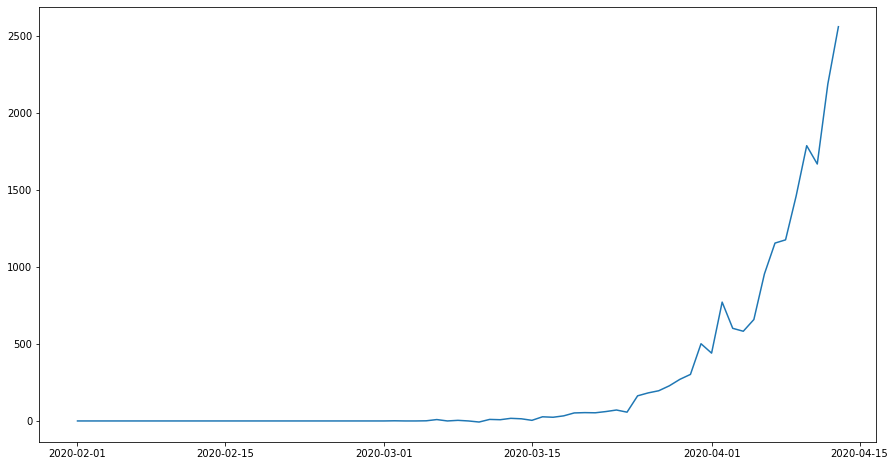

In [185]:
rus_data['diff1'] = rus_data['Confirmed'].diff(1)
plt.figure(figsize=(15, 8))
plt.plot(rus_data['diff1'])
plt.show()

Сделаем сглаживание для разностей 

Text(0.5, 1.0, 'COVID_19 RUS')

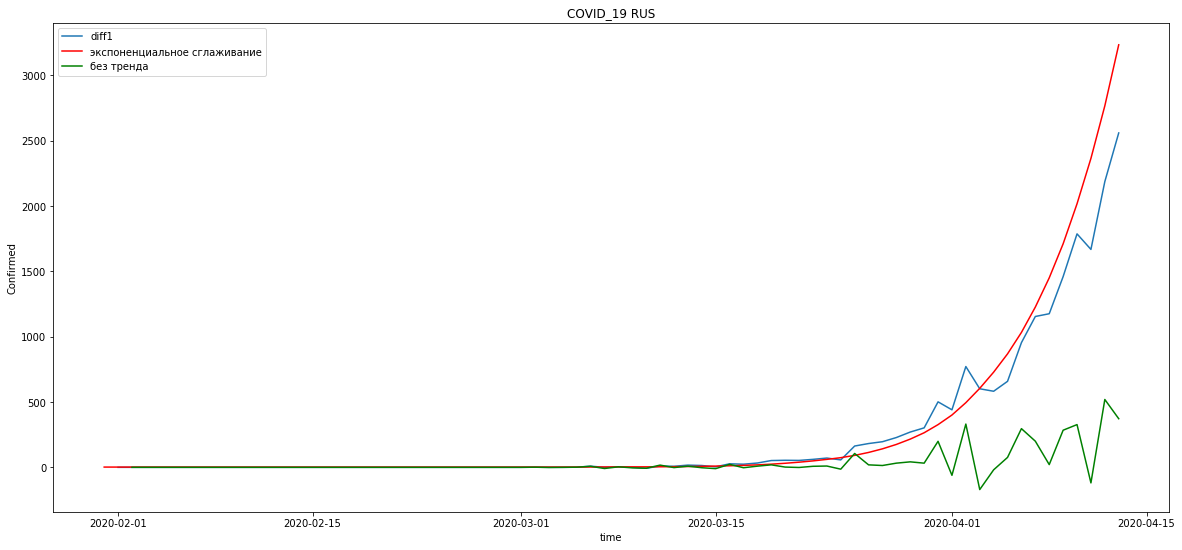

In [186]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

N2 = 24*7

exp_1 = exponential_smoothing(rus_data['Confirmed'], 0.03)

plt.figure(figsize=(20, 9))
plt.plot(rus_data.index, rus_data['diff1'], label='diff1')
plt.plot(rus_data.index, exp_1, color = 'red', label="экспоненциальное сглаживание")
plt.plot(rus_data.index, rus_data['diff1'] - rus_data['diff1'].shift(), color = 'green', label="без тренда")
plt.xlabel('time')
plt.ylabel('Confirmed')
plt.legend()
plt.title('COVID_19 RUS')

### Формирование признаков

In [187]:
df = pd.DataFrame(exp_1, index=rus_data.index)

In [188]:
 # добавим историю на глубину 5 измерения от текущего (р=5)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df['t3']=0
df.iloc[4:,4]=df.iloc[:-4,0].values
df['t4']=0
df.iloc[5:,5]=df.iloc[:-5,0].values
df.fillna(0)

df['exp_0_01'] = exponential_smoothing(df[0], 0.05)

# добавим историю разностей
df['diff1'] = 0
df['diff1'] = df[0].diff(1)
df['diff1'].fillna(0, inplace=True)
df['diff2'] = 0
df['diff2'].values[1:] = df['diff1'].values[:-1]
df['diff2'].fillna(0, inplace=True)
df['diff3'] = 0
df['diff3'].values[1:] = df['diff2'].values[:-1]
df['diff3'].fillna(0, inplace=True)
df['diff4'] = 0
df['diff4'].values[1:] = df['diff3'].values[:-1]
df['diff4'].fillna(0, inplace=True)
df['diff5'] = 0
df['diff5'].values[1:] = df['diff4'].values[:-1]
df['diff5'].fillna(0, inplace=True)

In [189]:
df

,0,t,t1,t2,t3,t4,exp_0_01,diff1,diff2,diff3,diff4,diff5
Data,,,,,,,,,,,,
2020-01-31,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0,0,0,0
2020-02-01,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0,0,0,0
2020-02-02,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0,0,0,0
2020-02-03,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0,0,0,0
2020-02-04,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09,1709.976607,1449.532585,1226.157304,1032.213715,867.962593,728.136694,415.051542,260.444022,223,193,164,139
2020-04-10,2016.187309,1709.976607,1449.532585,1226.157304,1032.213715,867.962593,495.108331,306.210702,260,223,193,164
2020-04-11,2363.221690,2016.187309,1709.976607,1449.532585,1226.157304,1032.213715,588.513998,347.034381,306,260,223,193


In [190]:
df_ = df.iloc[:,[0,1,2,3,6,7,8,9]].copy()

In [191]:
df_

,0,t,t1,t2,exp_0_01,diff1,diff2,diff3
Data,,,,,,,,
2020-01-31,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0,0
2020-02-01,2.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0,0
2020-02-02,2.000000,2.000000,2.000000,0.000000,2.000000,0.000000,0,0
2020-02-03,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0,0
2020-02-04,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...
2020-04-09,1709.976607,1449.532585,1226.157304,1032.213715,415.051542,260.444022,223,193
2020-04-10,2016.187309,1709.976607,1449.532585,1226.157304,495.108331,306.210702,260,223
2020-04-11,2363.221690,2016.187309,1709.976607,1449.532585,588.513998,347.034381,306,260


### Делим данные

In [192]:
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), data.loc[data.index > split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

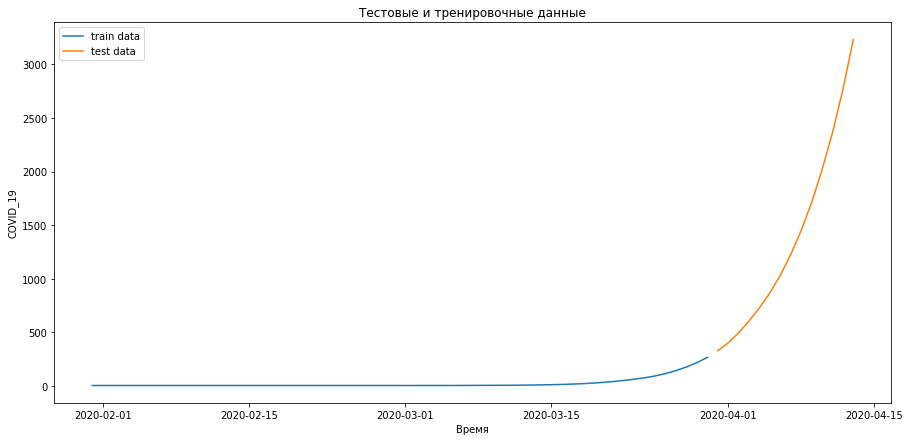

In [193]:
train, test = split_data(df_, '2020-03-30')

X_train = train.iloc[:-1,:]
y_train = train[0].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[0].values[1:]


plt.figure( figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('COVID_19')
plt.plot(train.index, train[df.columns[0]], label='train data')
plt.plot(test.index, test[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [194]:
# не знаю почему на графике пропуск, данные разбились верно

### Построим две модели, с глубиной прогноза h=1 и h =10

In [195]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [196]:
model = LinearRegression()
model.fit(X_train, y_train) 

X_test_pred = model.predict(X_test)

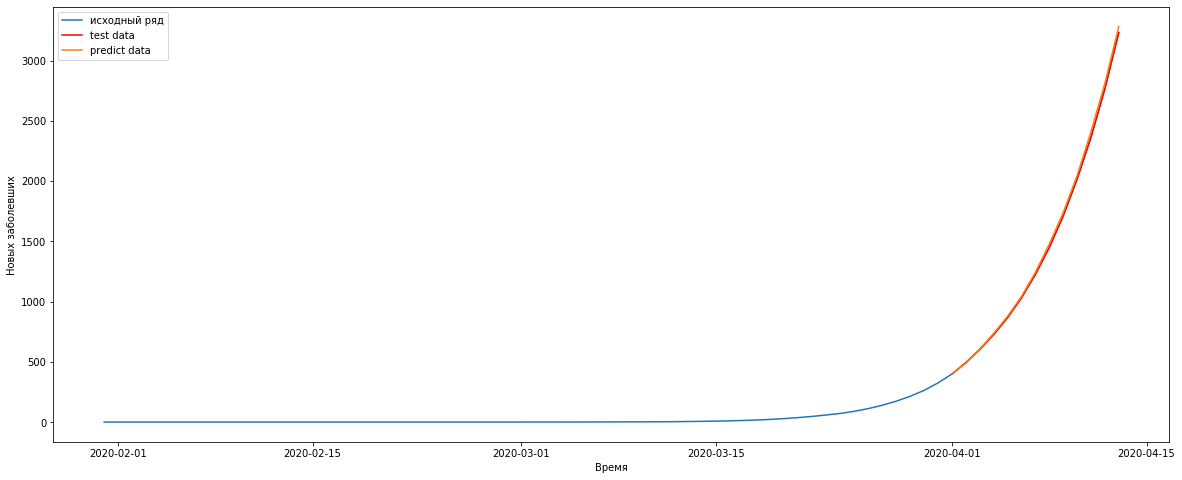

ошибка :   1.3176158448726645 %


In [197]:
plt.figure( figsize=(20, 8))
plt.xlabel('Время')
plt.ylabel('Новых заболевших')
plt.plot(df[0], label='исходный ряд')
plt.plot(test.index[1:],y_test, label='test data', color='r')
plt.plot(test.index[1:],X_test_pred, label='predict data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка :  ', er_g, '%')

Модель отработала неплохо

Теперь построим модель с h=10

In [198]:
h = 10
X_train = train.iloc[:-h,:]
y_train = train[0].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[0].values[h:]

model.fit(X_train, y_train) 
X_test_pred = model.predict(X_test)

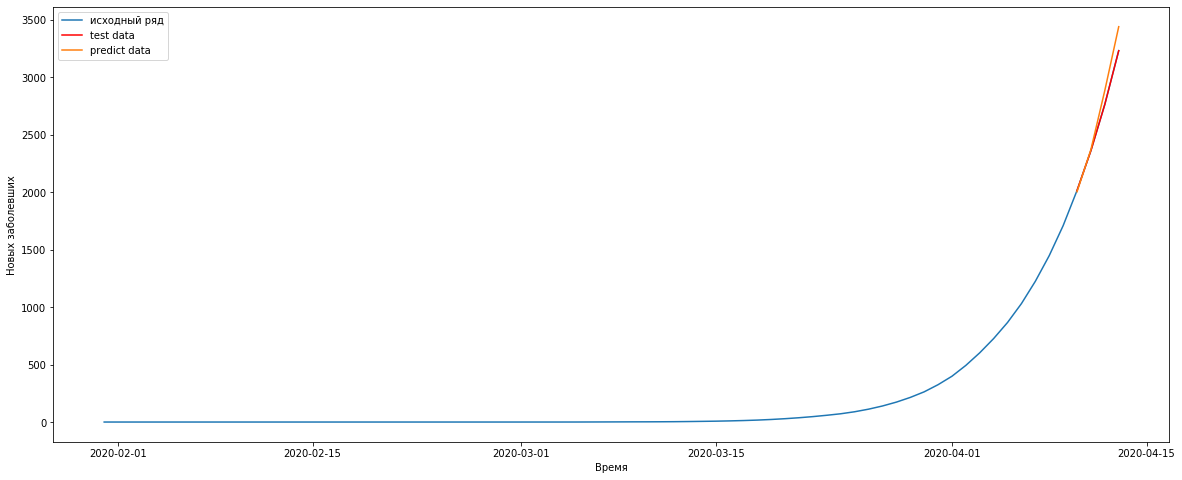

ошибка :   2.9479452227531144 %


In [199]:
plt.figure( figsize=(20, 8))
plt.xlabel('Время')
plt.ylabel('Новых заболевших')
plt.plot(df[0], label='исходный ряд')
plt.plot(test.index[h:],y_test, label='test data', color='r')
plt.plot(test.index[h:],X_test_pred, label='predict data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка :  ', er_g, '%')

Модель с h=10 отрабатывает немного хуже. Надо заметить, что добавление истории разниц в качестве признаков существенно повысило качество модели(без истории ошибка была >50%, теперь всего 3%)

### Предсказание на завтра по всем данным

In [200]:
test.iloc[-1, :]

0           3232.302288
t           2765.425039
t1          2363.221690
t2          2016.187309
exp_0_01     824.106687
diff1        466.877249
diff2        402.000000
diff3        347.000000
Name: 2020-04-13 00:00:00, dtype: float64

In [201]:
X = df_.iloc[:-1,:]
y = df_[0].values[1:]
model.fit(X, y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [202]:
tomorrow_pred = model.predict(test.values[-1, :].reshape(1, -1))
print(tomorrow_pred)

[3770.10315644]


###  ACF, PACF

Построим __ACF__ и __PACF__ для __экспоненциально сглаживанных разностей__ количества заболевших

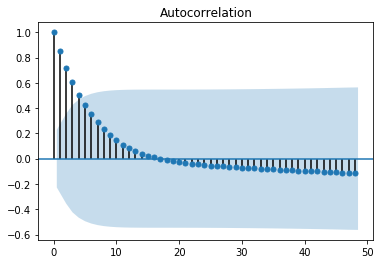

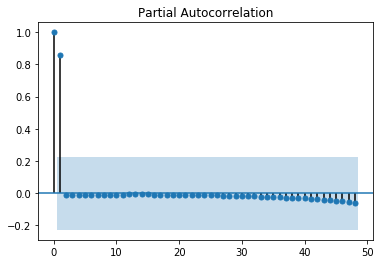

In [205]:
sm.graphics.tsa.plot_acf(df_[0].values, lags=24*2)
plt.show()

sm.graphics.tsa.plot_pacf(df_[0].values, lags=24*2)
plt.show()

Как видим по графику автокорреляции, в данных явно имеется тренд. Для разностей же наблюдаем, что есть __значительная корреляция с первым остатком__, однако с остальными связь полностью отсутствует. 

### ARIMA

Для экспоненциально сглаживанных разностей построить модель __ARIMA__ не получается, так как ряд не является стационарным. Поэтому модель ARIMA будем строить для разностей __без тренда__

In [206]:
data_model = rus_data['diff1']- rus_data['diff1'].shift()
data_model.fillna(0, inplace=True)

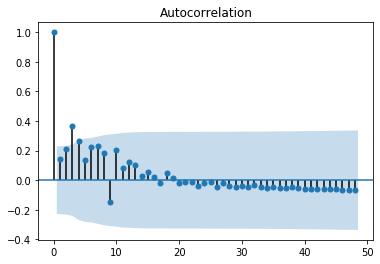

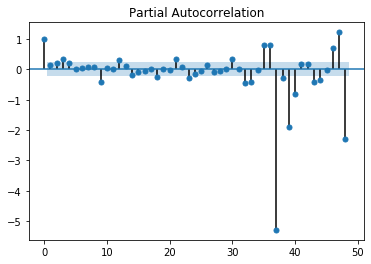

In [210]:
sm.graphics.tsa.plot_acf(data_model, lags=24*2)
plt.show()

sm.graphics.tsa.plot_pacf(data_model, lags=24*2)
plt.show()

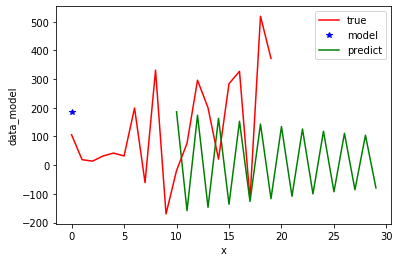

In [211]:
np.random.seed(21)
N=10

model = ARIMA(data_model[:-N], order=(1,0,1))
model_fit = model.fit(disp=False)

# делаем оценку старых значений
y_p = model_fit.predict(len(data_model[:-N]), len(data_model[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(data_model.values[-10-N:],'r',label ='true')
plt.plot(y_p.values,'*b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.xlabel('x')
plt.ylabel('data_model')
plt.legend()
plt.show()

__Оценка результата моделирования:__
- выбранные данные не совсем хорошо подходят для построения модели ARIMA.
- экспоненциально сглаживанные разности не могут быть включены в модель так как они не стационарны, а предсказания разностей без тренда не имеет особого смысла.